# Electromyography (EMG)

  <img align="left" src="https://my.clevelandclinic.org/-/scassets/images/org/health/articles/4825-electromyography" width=400 height=400>


  <p style="font-size: 40px;">
    Electromyography (EMG) is a technique for evaluating and recording the electrical activity produced by skeletal muscles EMG is performed using an instrument called an <b>electromyograph</b> to produce a record called an <b>electromyogram</b>.  An electromyograph detects the electric potential generated by muscle cells when these cells are electrically or neurologically activated.
    The signals can be analyzed to detect abnormalities, activation level, or recruitment order, or to analyze the biomechanics of human or animal movement. Needle EMG is an electrodiagnostic medicine technique commonly used by neurologists.
  </p>
  <a href="https://en.wikipedia.org/wiki/Electromyography" title="Wikipedia">https://en.wikipedia.org/wiki/Electromyography</a>






## Electrical Activity in Muscles

<img align="left" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/57/1009_Motor_End_Plate_and_Innervation.jpg/800px-1009_Motor_End_Plate_and_Innervation.jpg" width=400 height=400>

<img align="center" src="https://www.researchgate.net/profile/S-Nawab/publication/6886902/figure/fig1/AS:348550530650112@1460112330023/Pictorial-outline-of-the-decomposition-of-the-surface-EMG-signal-into-its-constituent.png" width=400 height=400>







<p>
A neuromuscular junction is a chemical synapse formed by the contact between a motor neuron and a muscle fiber. It is the site in which a motor neuron transmits a signal to a muscle fiber to initiate muscle contraction. The sequence of events that results in the depolarization of the muscle fiber at the neuromuscular junction begins when an action potential is initiated in the cell body of a motor neuron, which is then propagated by saltatory conduction along its axon toward the neuromuscular junction.
</p>

<a href="https://en.wikipedia.org/wiki/Muscle_contraction" title="Wikipedia">https://en.wikipedia.org/wiki/Muscle_contraction</a>

In [1]:
# Download the emg signal from UCI dataset repository
import urllib.request
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00213/EMG%20Physical%20Action%20Data%20Set.rar'
urllib.request.urlretrieve(url,'EMG_Physical_Action_Data_Set.rar')

('EMG_Physical_Action_Data_Set.rar',
 <http.client.HTTPMessage at 0x7cb7ef996a70>)

In [2]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 2.6 MB/s eta 0:00:00


In [3]:
# library for extracting rar files
import patoolib
patoolib.extract_archive("/content/EMG_Physical_Action_Data_Set.rar", outdir="/content")

INFO patool: Extracting /content/EMG_Physical_Action_Data_Set.rar ...
INFO:patool:Extracting /content/EMG_Physical_Action_Data_Set.rar ...
INFO patool: running /usr/bin/unrar x -- /content/EMG_Physical_Action_Data_Set.rar
INFO:patool:running /usr/bin/unrar x -- /content/EMG_Physical_Action_Data_Set.rar
INFO patool:     with cwd='/content', input=''
INFO:patool:    with cwd='/content', input=''
INFO patool: ... /content/EMG_Physical_Action_Data_Set.rar extracted to `/content'.
INFO:patool:... /content/EMG_Physical_Action_Data_Set.rar extracted to `/content'.


'/content'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import signal

from datetime import datetime

In [5]:
# get col names from readme.txt
col_names = []
with open("/content/EMG Physical Action Data Set/readme.txt", 'r',encoding="ISO-8859-1") as f:
    cnt=0
    for line in f:
      if "Muscle:" in line:
        cnt+=1
        continue
      if cnt>=1 and cnt<=8:
        splt = line.split(":")
        name = splt[-1].strip().title()
        col_names.append(name)
        cnt+=1

print(col_names,sep="\t")

['Right Bicep (C1)', 'Right Tricep (C2)', 'Left Bicep (C3)', 'Left Tricep (C4)', 'Right Thigh (C5)', 'Right Hamstring (C6)', 'Left Thigh (C7)', 'Left Hamstring (C8)']


In [6]:
data_aa = pd.read_csv('/content/EMG Physical Action Data Set/sub2/Aggressive/txt/Pushing.txt', sep='\t', header=None, names=col_names,encoding='utf-8')
data_na = pd.read_csv('/content/EMG Physical Action Data Set/sub2/Normal/txt/Seating.txt', sep='\t', header=None, names=col_names,encoding='utf-8')

In [7]:
print("Shape of data aggresive: {} normal: {}".format(data_aa.shape,data_na.shape))

Shape of data aggresive: (10000, 8) normal: (10000, 8)


In [8]:
data_aa.head()

,Right Bicep (C1),Right Tricep (C2),Left Bicep (C3),Left Tricep (C4),Right Thigh (C5),Right Hamstring (C6),Left Thigh (C7),Left Hamstring (C8)
0,2080,1461,-477,-1692,2243,28,244,-1042
1,1761,1201,-239,-1211,1987,146,163,-953
2,1515,1323,-171,-1431,1091,-125,341,-859
3,1645,1591,-163,-1335,607,-219,341,-862
4,1580,1120,-280,-914,1376,15,243,-982


In [9]:
data_na.head()

,Right Bicep (C1),Right Tricep (C2),Left Bicep (C3),Left Tricep (C4),Right Thigh (C5),Right Hamstring (C6),Left Thigh (C7),Left Hamstring (C8)
0,15,11,4,1,37,46,31,20
1,7,10,5,6,28,44,17,14
2,4,11,-5,-24,20,23,15,12
3,-7,7,-20,-25,20,17,17,5
4,-9,-3,-18,-33,7,21,-4,-19


In [10]:
def plot_waveform(data,n_sample,row,col,gen_title):
  fig, ax = plt.subplots(row,col,figsize=(18, 5))
  ax = ax.flatten()
  cols = data.columns

  for idx,ax in enumerate(ax):
    ax.plot(data[:n_sample].iloc[:,idx])
    ax.set_title(cols[idx])

  fig.suptitle(gen_title,fontsize=14,weight = 'extra bold')
  fig.supxlabel(r'index')
  fig.supylabel(r'voltage ($\mu$V)')
  plt.tight_layout()

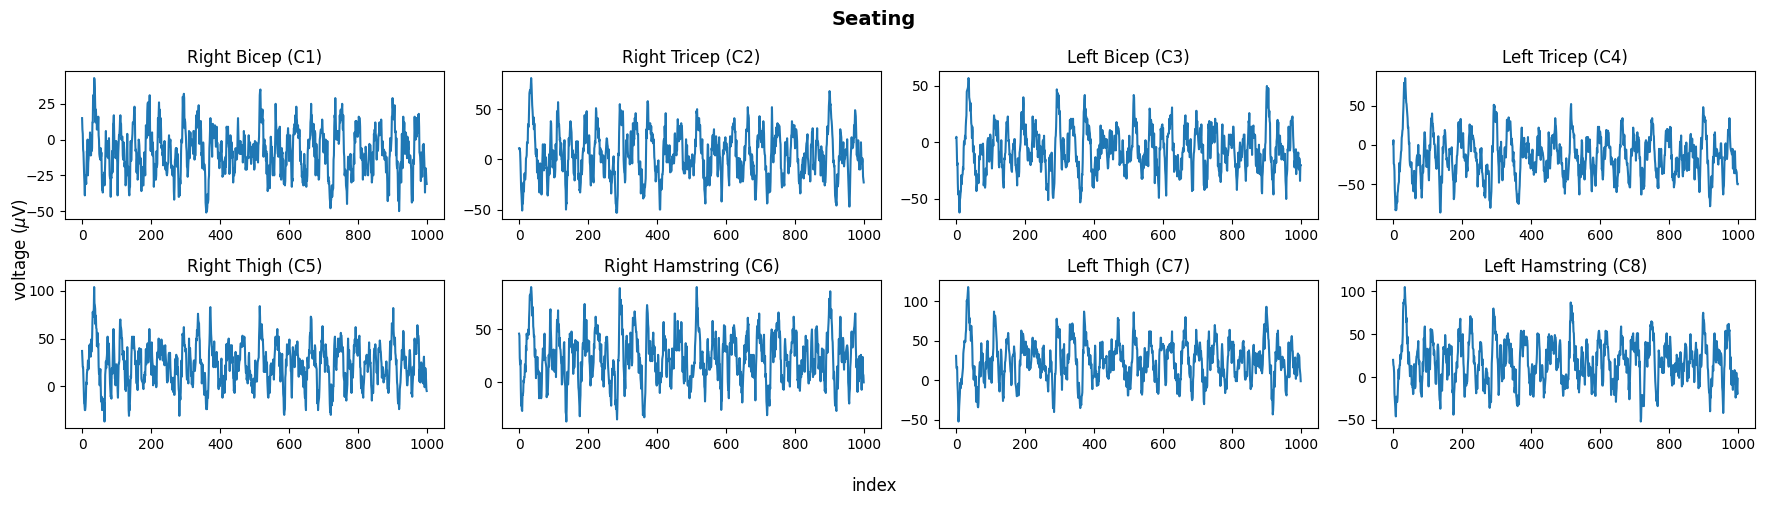

In [11]:
plot_waveform(data_na,1000,2,4,"Seating")

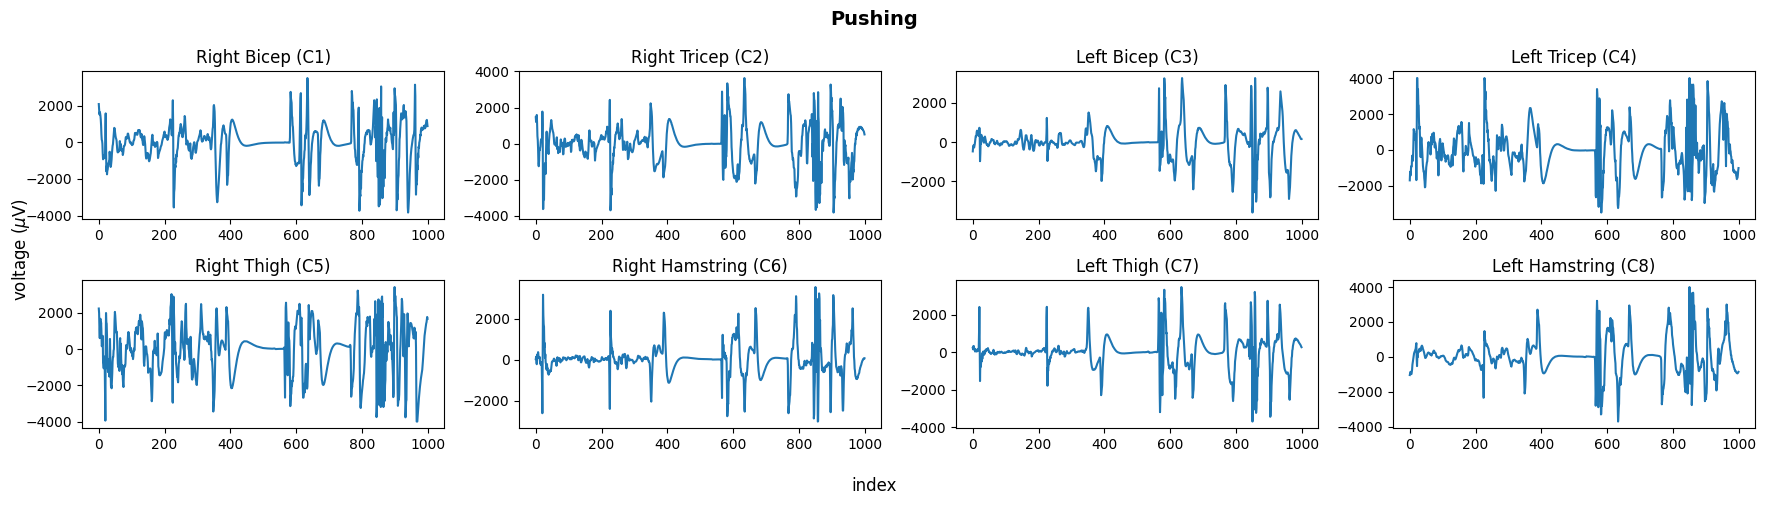

In [12]:
plot_waveform(data_aa,1000,2,4,"Pushing")

In [13]:
def read_log_file(activity_type,activity):
  format_data = '%d/%m/%Y %H:%M:%S'
  start=0
  end=0
  with open("/content/EMG Physical Action Data Set/sub2/{}/log/{}.log".format(activity_type,activity), 'r',encoding="ISO-8859-1") as f:
      for line in f:
          if 'Start' in line:
            s = line.split('=')[-1].strip()
            start = datetime.strptime(s, format_data)
          elif 'End' in line:
            e = line.split('=')[-1].strip()
            end = datetime.strptime(e, format_data)
  time_diff = end - start
  duration = time_diff.seconds
  return duration

In [14]:
duration_na = read_log_file("Normal","Seating")
duration_aa = read_log_file("Aggressive","Pushing")
print("Duration of records are {} {}".format(duration_na,duration_aa))

Duration of records are 10 10


In [15]:
fs_aa = data_na.iloc[:,1].size // duration_na # sampling frequency of aggressive activity signals
fs_na = data_aa.iloc[:,1].size // duration_aa # sampling frequency of normal activity signals
print(" fs_aa: {}\n fs_na: {}".format(fs_aa,fs_na))

 fs_aa: 1000
 fs_na: 1000


In [16]:
data_aa_ch2 = data_aa.iloc[:,1].to_numpy() # rigth tricep muscle aggressive activity
data_na_ch2 = data_na.iloc[:,1].to_numpy() # rigth tricep muscle normal activity

In [17]:
# create time axis
t = np.arange(0,duration_aa,1/fs_aa)

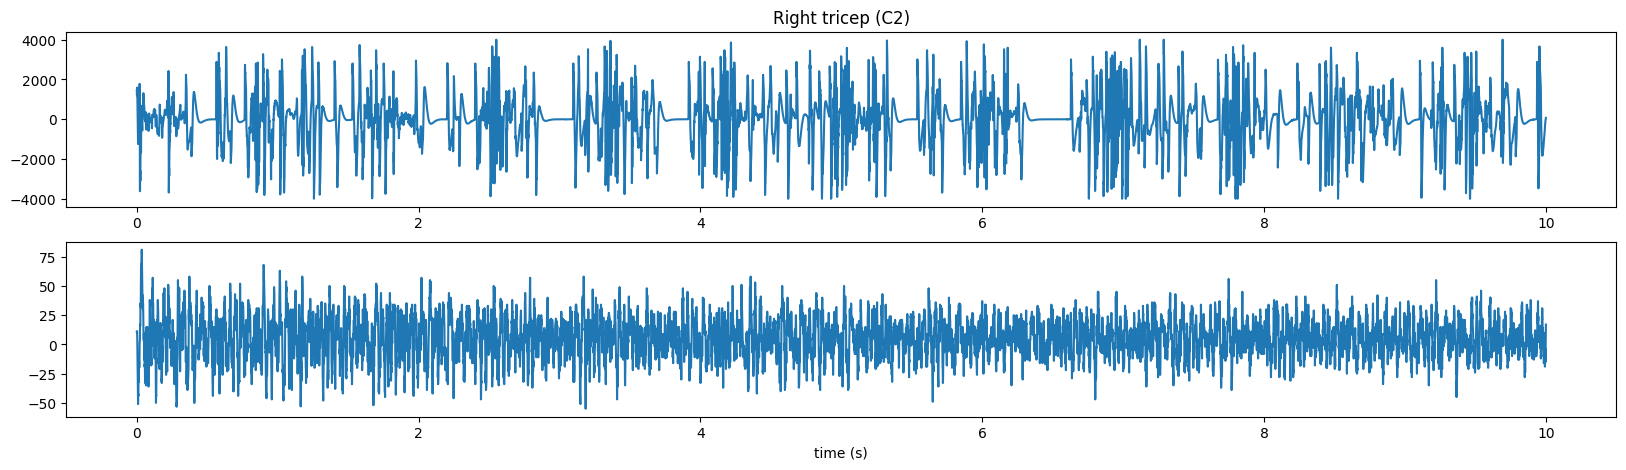

In [18]:
# plot signals with time axis
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(t,data_aa_ch2)
plt.subplot(2,1,2)
plt.plot(t,data_na_ch2)

plt.subplot(2,1,1);plt.title('Right tricep (C2)')
plt.subplot(2,1,2);plt.xlabel('time (s)')
plt.show()

In [19]:
def plot_frequency_response(x_n,fs, frequency_point_num=500):
  X_f = np.fft.fft(x_n, frequency_point_num * 2)
  X_f = X_f[:frequency_point_num]
  f_ax = np.linspace(0,fs//2,frequency_point_num)

  genlik_w = np.abs(X_f)
  faz_w = np.unwrap(np.angle(X_f))

  plt.figure(figsize=(12,3))

  plt.subplot(1,2,1)
  plt.title('Amplitude Spectrum')
  plt.plot(f_ax,genlik_w, 'b')
  plt.ylabel('|X(f)|')
  plt.xlabel('frequency [Hz]')
  plt.grid()

  plt.subplot(1,2,2)
  plt.title('Phase Spectrum')
  plt.plot(f_ax,faz_w, 'g')
  plt.ylabel('phase(X(f)) (radian)')
  plt.xlabel('frequency [Hz]')
  plt.grid()
  plt.show()

#### Spectrum of emg signal from **right tricep** during **aggressive activity (pushing)**

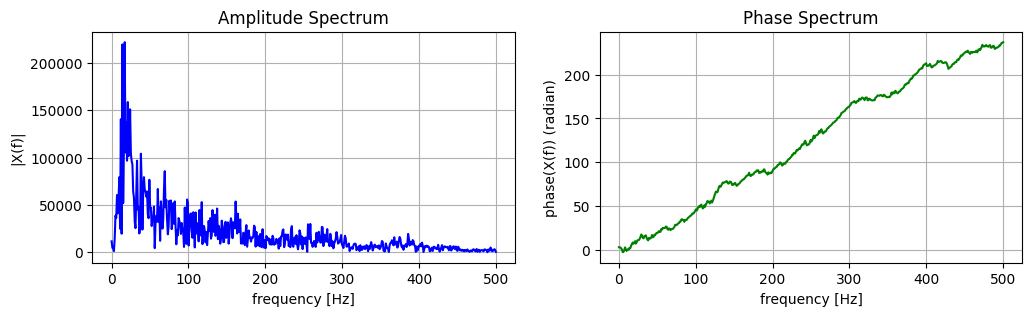

In [20]:
plot_frequency_response(data_aa_ch2,fs_aa)

#### Spectrum of emg signal from **right tricep** during **normal activity (seating)**

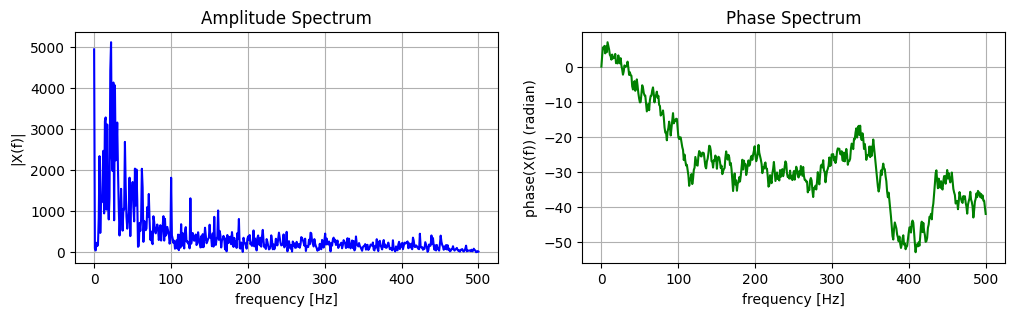

In [21]:
plot_frequency_response(data_na_ch2,fs_na)

In [22]:
data_na_ch2 = data_na_ch2 - np.mean(data_na_ch2) # remove dc component

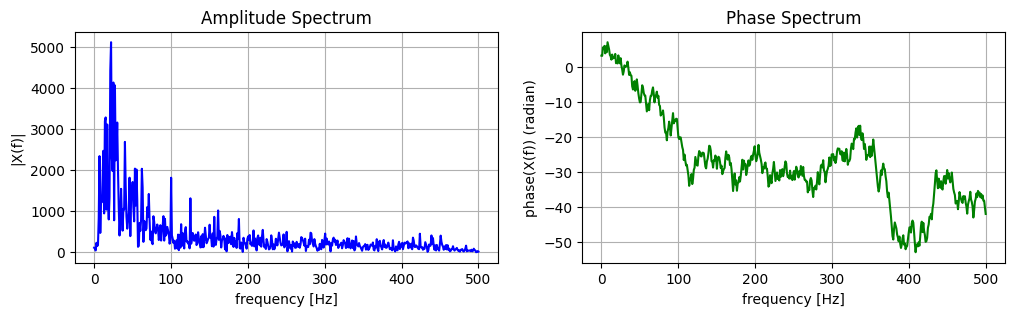

In [23]:
plot_frequency_response(data_na_ch2,fs_na) # frequency response after mean correction

## Noise Filtering


In [24]:
# band-pass Butterworth filter at 10-400Hz
f_max = fs_aa // 2
f_c = np.array([10, 400]) # cut-off frequencies
f_norm = f_c / f_max
b, a = signal.butter(2, f_norm, btype = 'bandpass')
data_aa_ch2_flt = signal.filtfilt(b,a,data_aa_ch2) # filtered signal

In [25]:
def filter_frequency_response(a, b):
  w, h = signal.freqz(b, a)
  w /= np.pi
  h[h < np.finfo(float).eps] = np.finfo(float).eps

  plt.figure(figsize=(10,4))
  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.set_title('Amplitude Spectrum')
  ax1.plot(w, 20*np.log10(abs(h)), 'b')
  ax1.set_ylabel('Amplitude [dB]', color='b')
  ax1.grid()

  angles = np.unwrap(np.angle(h))
  ax2.set_title('Phase Spectrum')
  ax2.plot(w, angles, 'g')
  ax2.set_ylabel('phase (radyan)', color='g')
  ax2.grid()
  fig.supxlabel('Normalized frequency [$\pi$ radian/sample]')
  plt.tight_layout()
  plt.show()

<Figure size 1000x400 with 0 Axes>

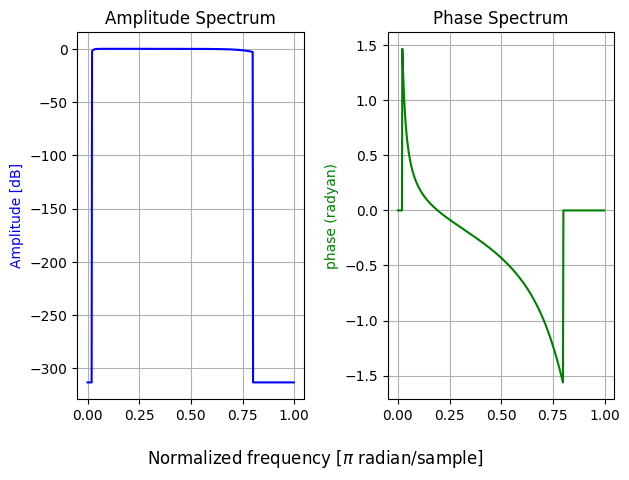

In [26]:
filter_frequency_response(a,b)

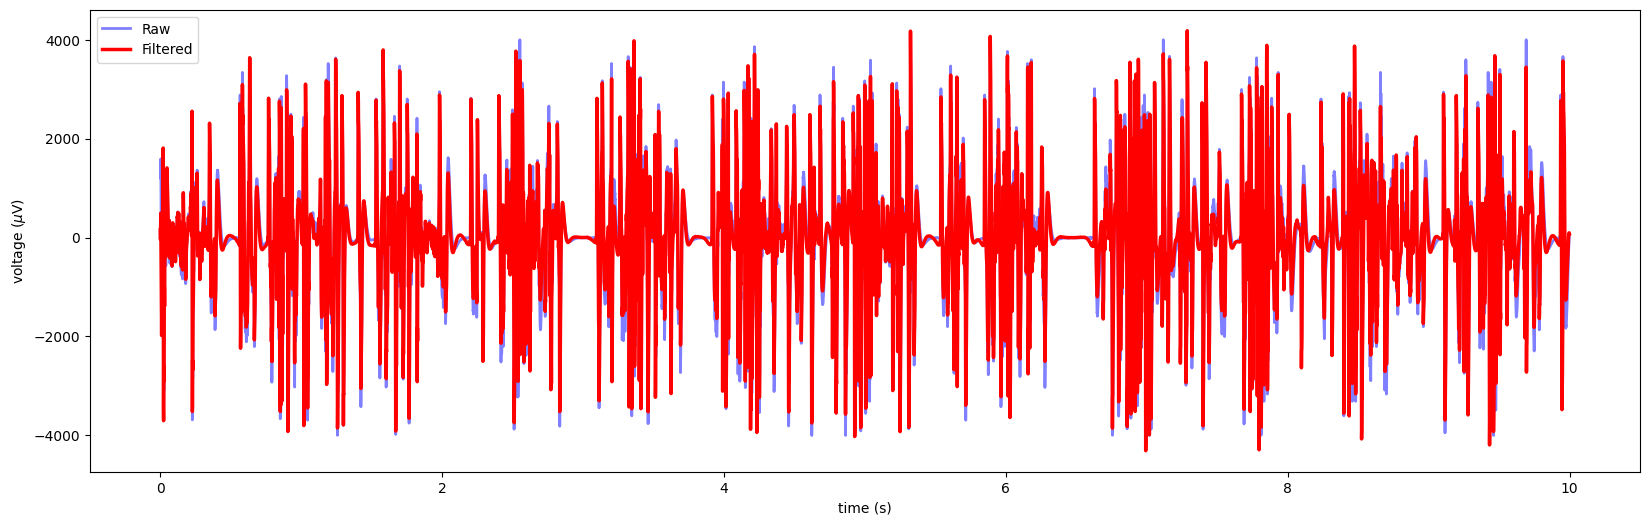

In [27]:
# plot raw and filtered EMG signal
plt.figure(figsize=(20,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(t,data_aa_ch2, 'b', linewidth=2.0, alpha=0.5, label="Raw")
plt.plot(t,data_aa_ch2_flt, 'r', linewidth=2.5, label="Filtered")
plt.legend()
plt.show()

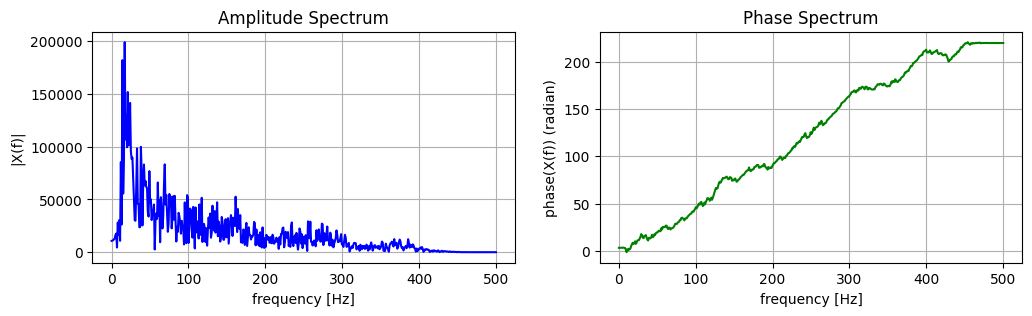

In [28]:
plot_frequency_response(data_aa_ch2_flt,fs_aa) # filtered signal spectrum

Power lines noise cleaning (50 Hz or 60 Hz)

<Figure size 1000x400 with 0 Axes>

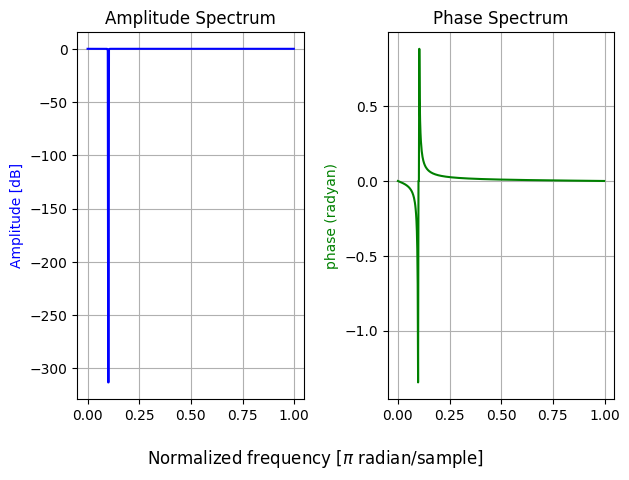

In [29]:
# notch filter for 50 Hz frequency
f_c = np.array([49, 51]) # cut-off frequencies
f_norm = f_c / f_max

b1, a1 = signal.butter(2, f_norm, btype='bandstop') # Band Stop Filter

data_aa_ch2_flt = signal.filtfilt(b1, a1, data_aa_ch2_flt) # 50 Hz filtered signal
filter_frequency_response(a1,b1) # band-stop filter frequency response

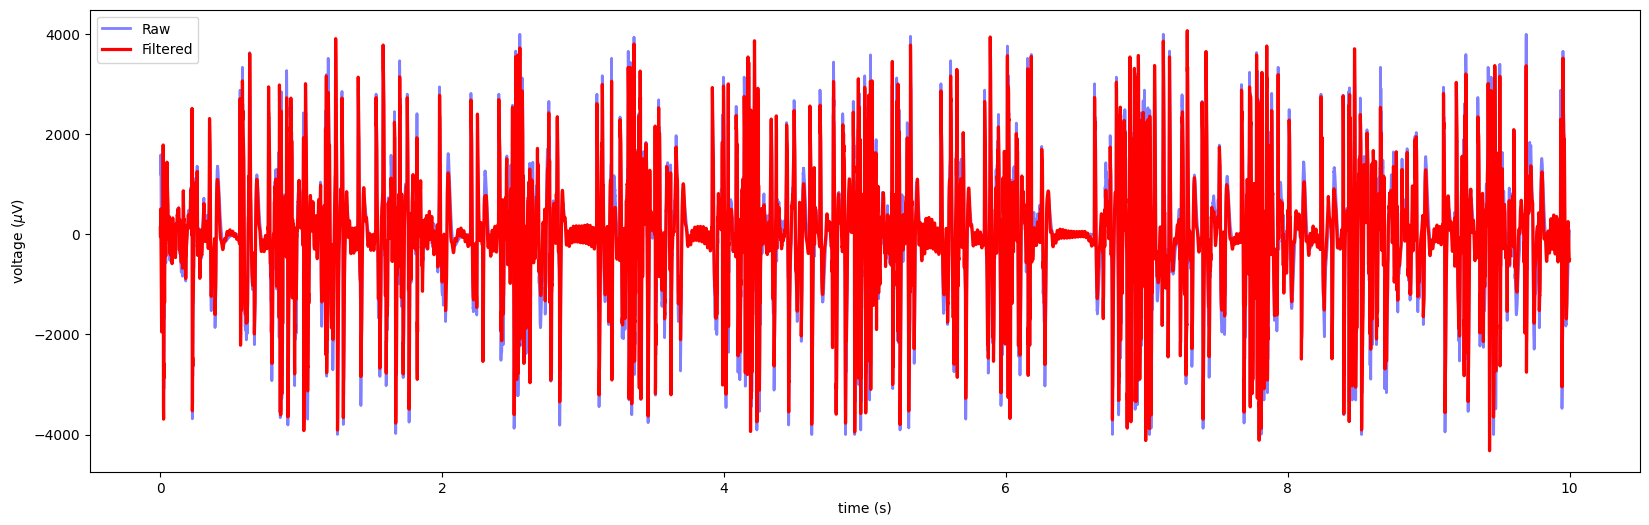

In [30]:
# plot raw and filtered EMG signal
plt.figure(figsize=(20,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(t,data_aa_ch2, 'b', linewidth=2.0, alpha=0.5, label="Raw")
plt.plot(t,data_aa_ch2_flt, 'r', linewidth=2.3, label="Filtered")
plt.legend()

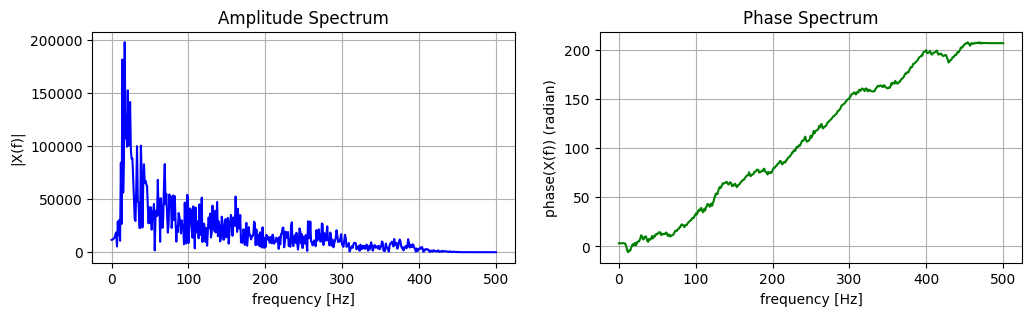

In [31]:
plot_frequency_response(data_aa_ch2_flt,fs_aa)

### Muscle Contraction Analysis

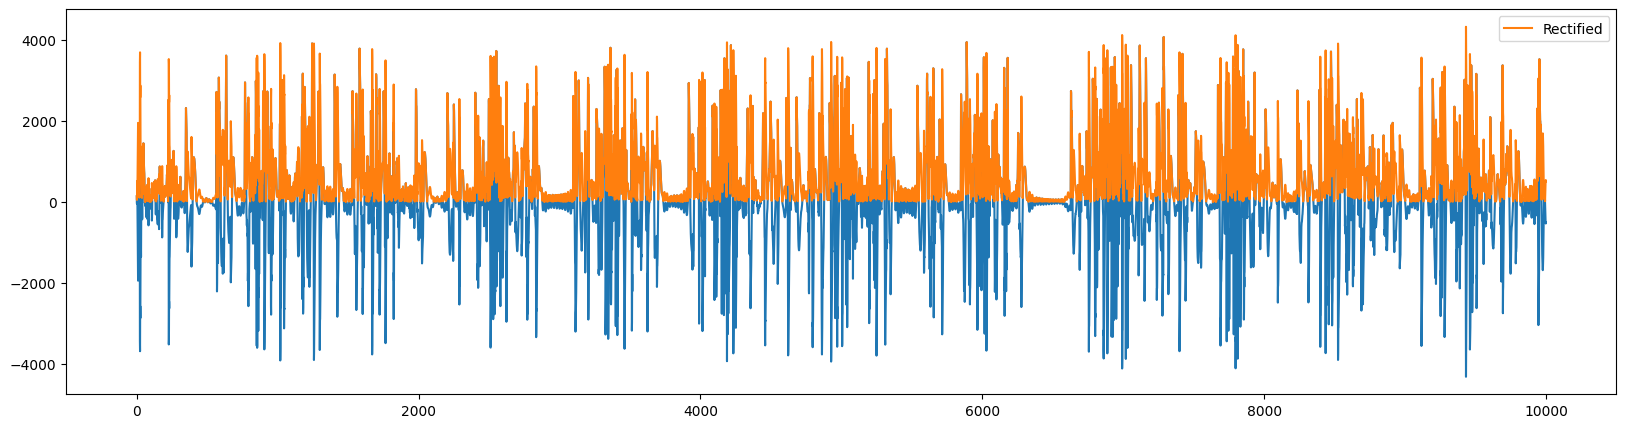

In [32]:
# Rectify the EMG signal
rectified_signal = np.abs(data_aa_ch2_flt)
plt.figure(figsize=(20,5))
plt.plot(data_aa_ch2_flt)
plt.plot(rectified_signal,label="Rectified")
plt.legend()
plt.show()

<Figure size 1000x400 with 0 Axes>

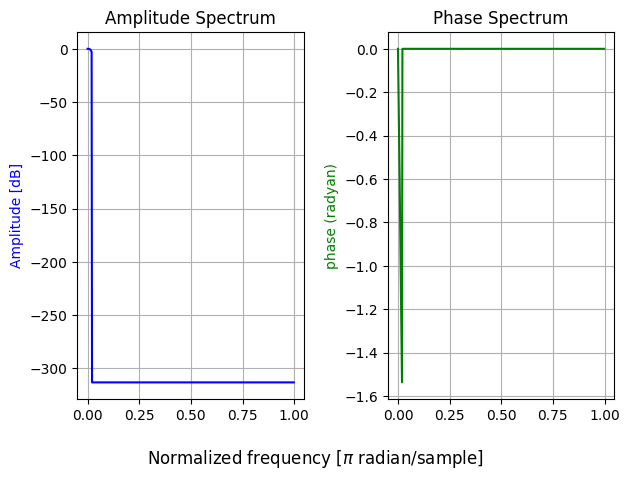

In [33]:
# signal trend or envelope
b2, a2 = signal.butter(2, 10/f_max, btype = 'lowpass')
signal_envelope = signal.filtfilt(b2, a2, rectified_signal)
filter_frequency_response(a2,b2)

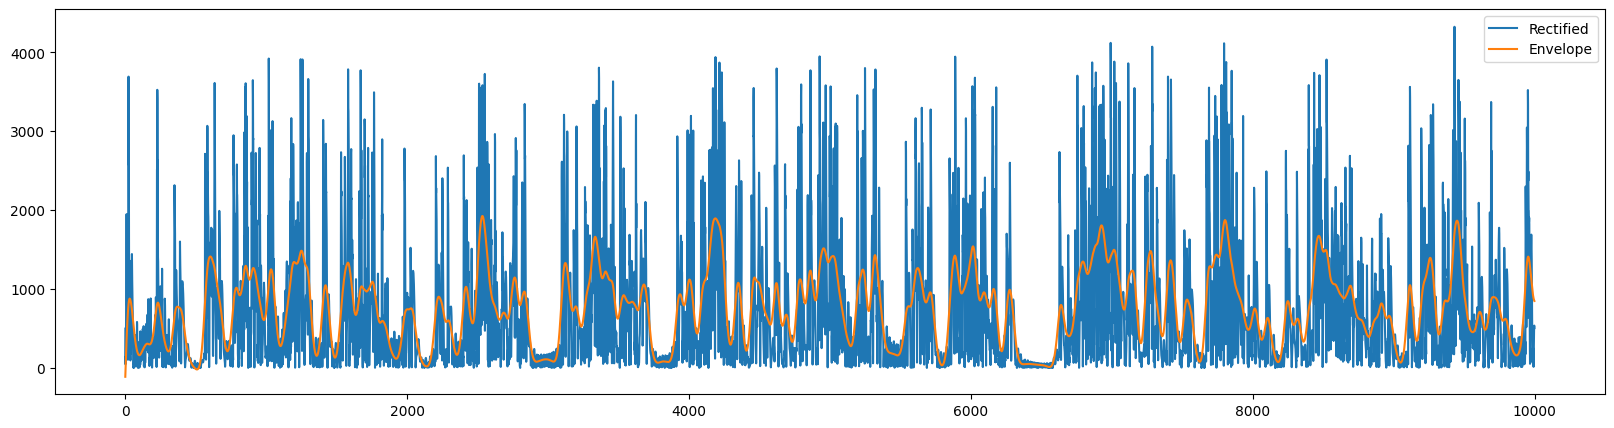

In [34]:
# visualize envelope and rectified signal together
plt.figure(figsize=(20,5))
plt.plot(rectified_signal,label="Rectified")
plt.plot(signal_envelope,label="Envelope")
plt.legend()
plt.show()

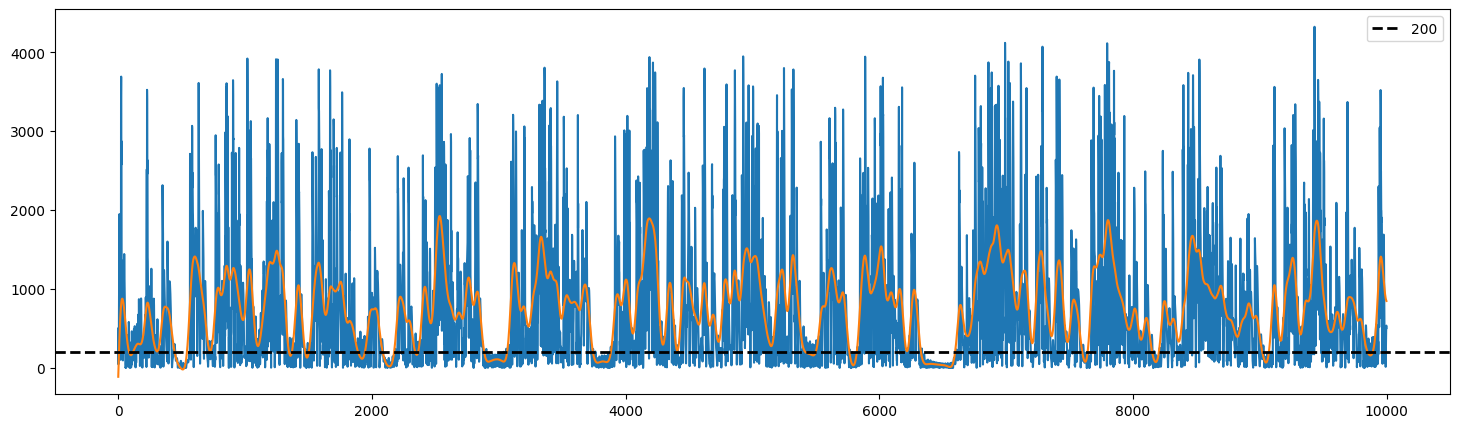

In [35]:
# pick threshold for muscle constraction analysis
threshold = 200
plt.figure(figsize=(18,5))
plt.plot(rectified_signal)
plt.plot(signal_envelope)
plt.axhline(y=threshold, color='k',linewidth=2.0, linestyle='--',label="200")
plt.legend()
plt.show()

In [36]:
cstarts = [] # constraction start indexes
for i in range(1, len(signal_envelope)):
    if signal_envelope[i-1] < threshold and signal_envelope[i] >= threshold:
        cstarts.append(i)

print(cstarts)
print(len(cstarts))

[6, 117, 542, 1370, 1503, 1945, 2175, 2365, 3067, 3884, 5500, 5823, 6599, 7644, 8205, 9073, 9892]
17


In [37]:
cstops = [] # constraction stop indexes
for i in range(1, len(signal_envelope)):
    if signal_envelope[i-1] >= threshold and signal_envelope[i] < threshold:
        cstops.append(i)

print(cstops)
print(len(cstops))

[86, 445, 1347, 1475, 1892, 2086, 2342, 2886, 3743, 5418, 5765, 6330, 7601, 8152, 9021, 9851]
16


In [38]:
# calculate how many seconds the contraction indexes correspond to
starts=[]
for n in range(0, len(cstarts)):
    starttime = cstarts[n]/fs_aa
    starts.append(starttime)

starts.pop()
print(starts)

stops=[]
for n in range(0, len(cstops)):
    stoptime = cstops[n]/fs_aa
    stops.append(stoptime)

print(stops)

[0.006, 0.117, 0.542, 1.37, 1.503, 1.945, 2.175, 2.365, 3.067, 3.884, 5.5, 5.823, 6.599, 7.644, 8.205, 9.073]
[0.086, 0.445, 1.347, 1.475, 1.892, 2.086, 2.342, 2.886, 3.743, 5.418, 5.765, 6.33, 7.601, 8.152, 9.021, 9.851]


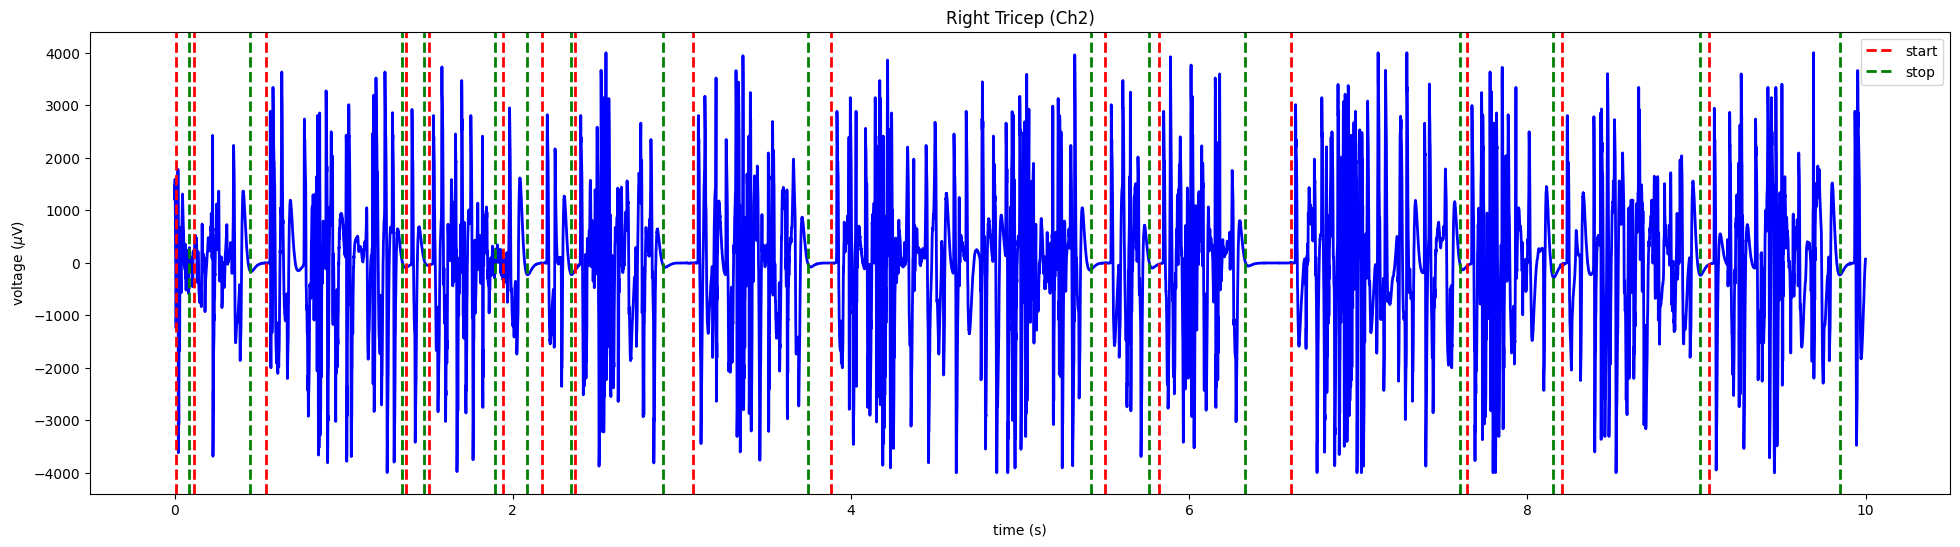

In [39]:
# plot envelope with contraction start and stop times marked by dashed lines
plt.figure(figsize=(24,6))
plt.xlabel("time (s)")
plt.ylabel("voltage ($\mu$V)")
plt.title("Right Tricep (Ch2)")
plt.plot(t, data_aa_ch2, 'b', linewidth=2.0) # raw data
for n in range(0, len(starts)):
    plt.axvline(x=starts[n], color='r',linewidth=2.0, linestyle='--')
for n in range(0, len(stops)):
    plt.axvline(x=stops[n], color='g',linewidth=2.0, linestyle='--')
# legend section
colors = ['red', 'green']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='--') for c in colors]
labels = ['start','stop']
plt.legend(lines, labels)

In [40]:
# calculate and print the contraction durations in seconds
durs=[]
for n in range(0,len(starts)):
    dur = stops[n]-starts[n]
    durs.append(round(dur,1))

durs = np.array(durs)
durs

array([0.1, 0.3, 0.8, 0.1, 0.4, 0.1, 0.2, 0.5, 0.7, 1.5, 0.3, 0.5, 1. ,
       0.5, 0.8, 0.8])

In [41]:
total_cont_time= np.sum(durs)
print("contraction time is {} seconds".format(round(total_cont_time,1)))

contraction time is 8.6 seconds


### STFT

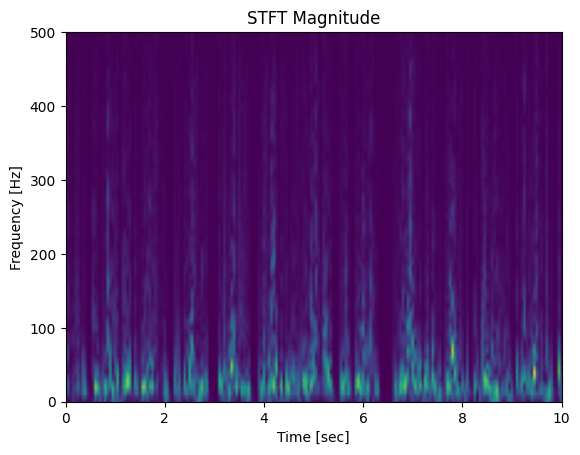

In [42]:
f, t, Zxx = signal.stft(data_aa_ch2, fs_aa, nperseg=100)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()